# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# simple plotting setup
%matplotlib inline
sns.set(style="whitegrid")

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv
df = pd.read_csv("porter_data_1.csv")

# quick peek at the data
print("Shape:", df.shape)
df.head()

Shape: (175777, 14)


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

# quick checking
df[['created_at', 'actual_delivery_time']].head()

,created_at,actual_delivery_time
0,2015-02-06 22:24:17,2015-02-06 23:11:17
1,2015-02-10 21:49:25,2015-02-10 22:33:25
2,2015-02-16 00:11:35,2015-02-16 01:06:35
3,2015-02-12 03:36:46,2015-02-12 04:35:46
4,2015-01-27 02:12:36,2015-01-27 02:58:36


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type
cat_cols = ['market_id', 'store_primary_category', 'order_protocol']

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

df[cat_cols].dtypes

,0
market_id,category
store_primary_category,category
order_protocol,category


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
df['delivery_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# checking
print("Missing delivery_minutes:", df['delivery_minutes'].isna().sum())
df['delivery_minutes'].describe()

Missing delivery_minutes: 0


,delivery_minutes
count,175777.000000
mean,46.203013
std,9.327424
min,32.000000
25%,39.000000
50%,45.000000
75%,52.000000
max,110.000000


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek  # Mon=0 ... Sun=6

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].isin([5, 6]).astype('category')

# quick checking
df[['order_hour', 'order_dayofweek', 'isWeekend']].head()

,order_hour,order_dayofweek,isWeekend
0,22,4,False
1,21,1,False
2,0,0,False
3,3,3,False
4,2,1,False


In [8]:
# Drop unnecessary columns
to_drop = ['created_at', 'actual_delivery_time']
df = df.drop(columns=[c for c in to_drop if c in df.columns])

df.head(3)

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,delivery_minutes,order_hour,order_dayofweek,isWeekend
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,False
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,False
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,False


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [9]:
# Define target variable (y) and features (X)
y = df['delivery_minutes']
X = df.drop(columns=['delivery_minutes'])

X.shape, y.shape

((175777, 15), (175777,))

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [10]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (140621, 15) (140621,)
Validation: (35156, 15) (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

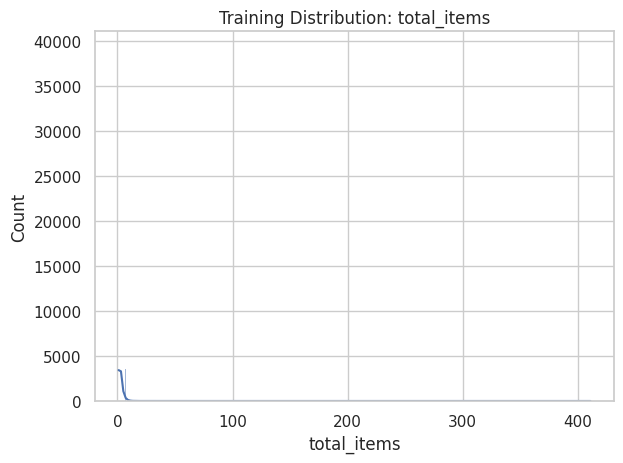

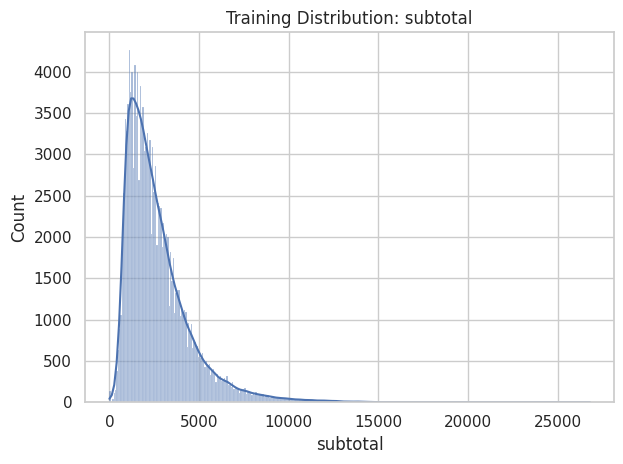

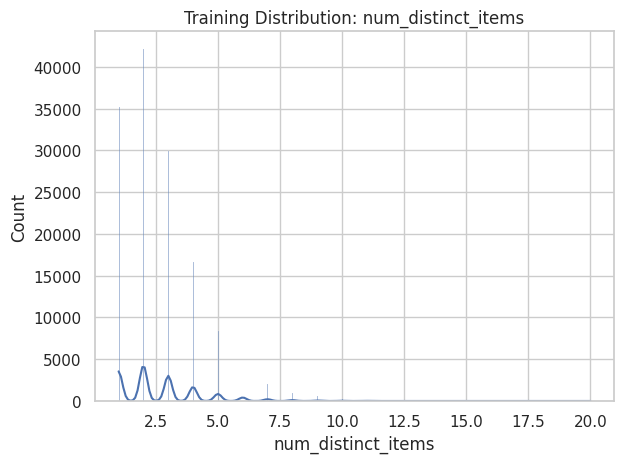

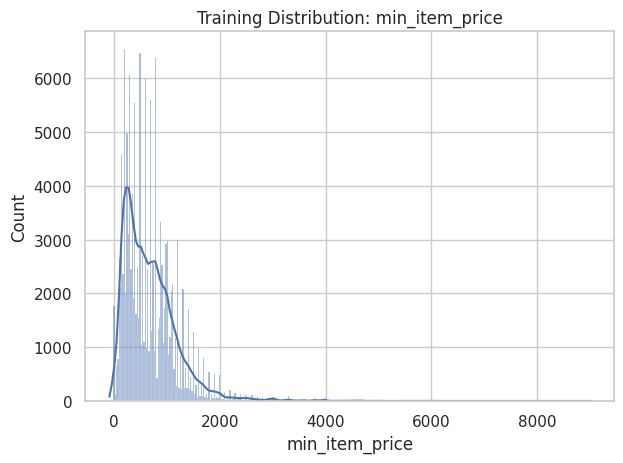

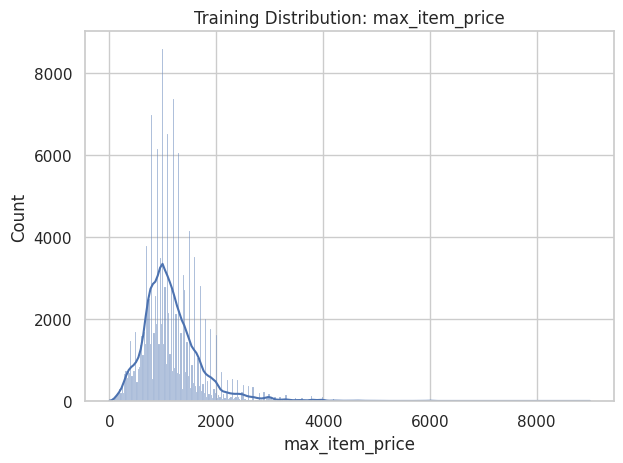

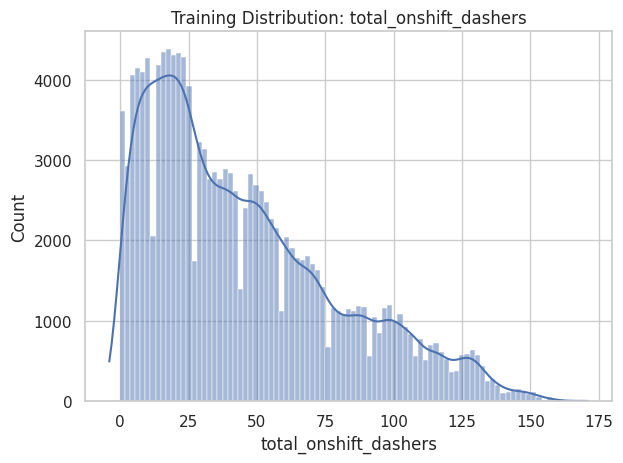

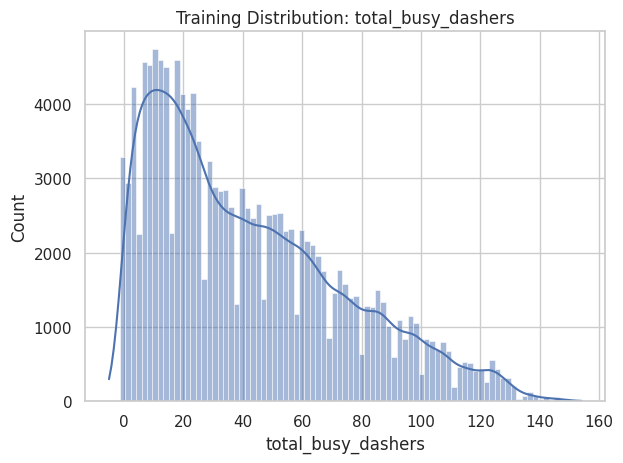

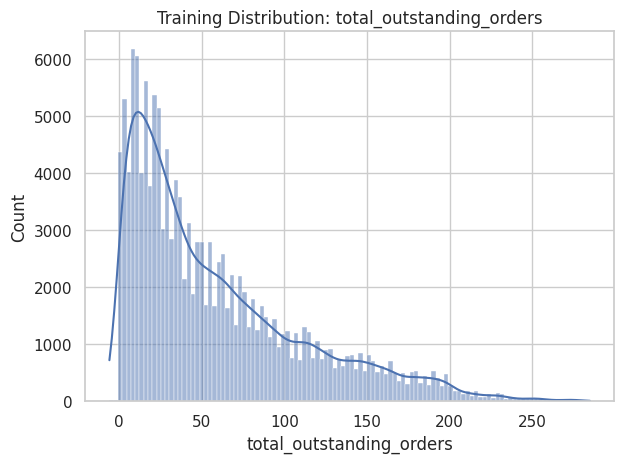

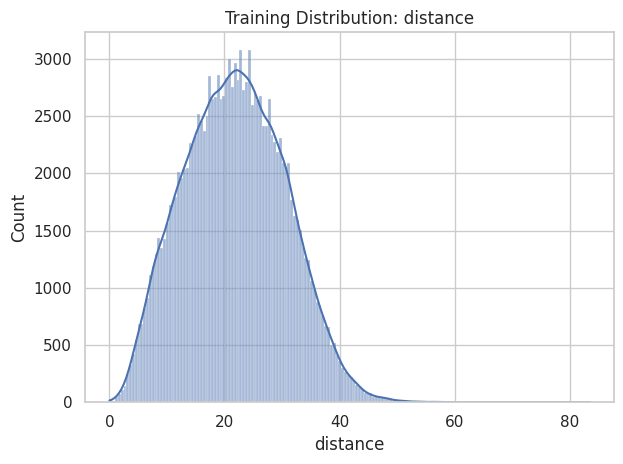

In [12]:
# Plot distributions for all numerical columns
for col in num_cols:
    plt.figure()
    sns.histplot(X_train[col].dropna(), kde=True)
    plt.title(f"Training Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

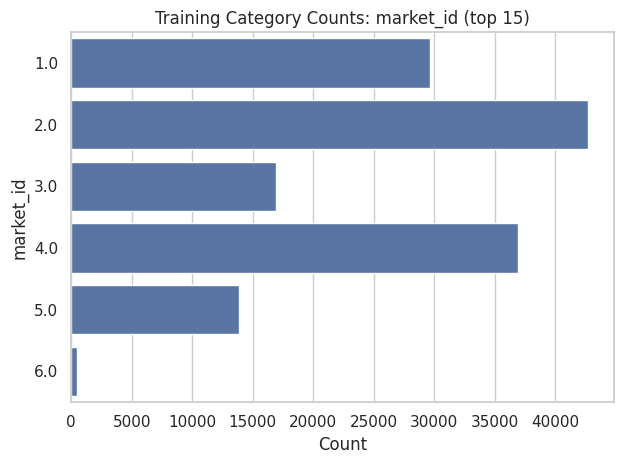

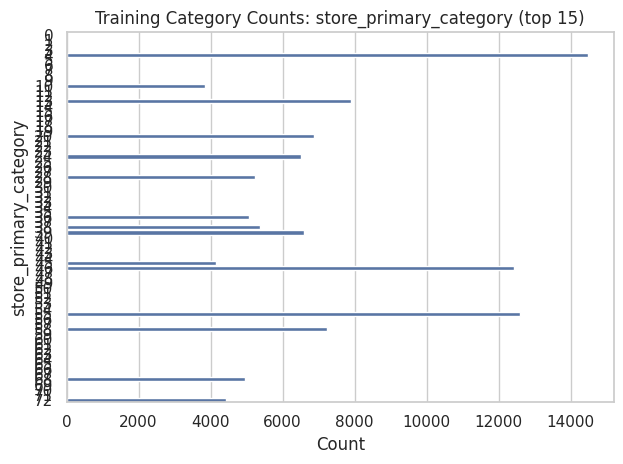

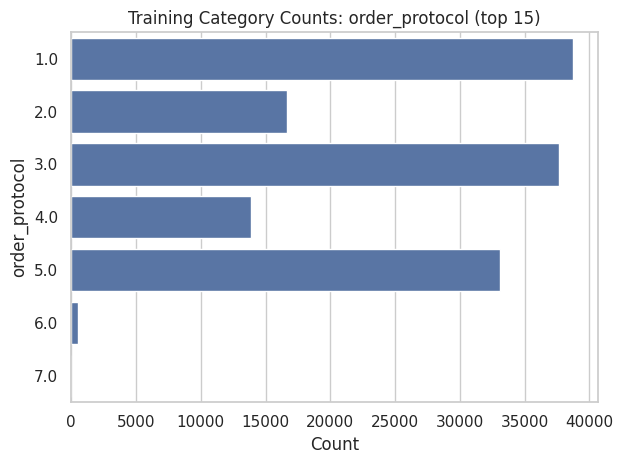

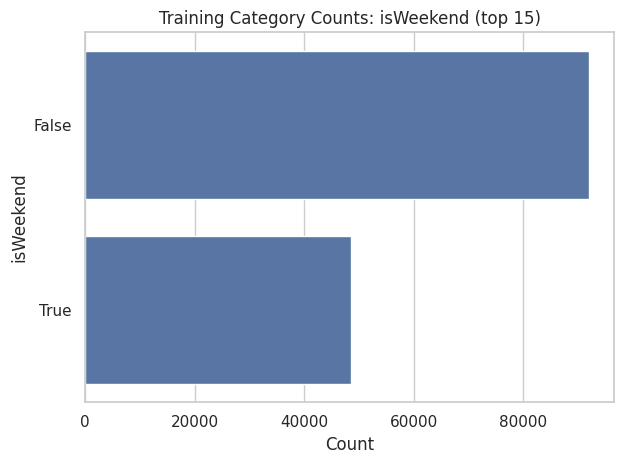

In [13]:
# Distribution of categorical columns
for col in cat_cols:
    plt.figure()
    vc = X_train[col].value_counts().head(15)  # show top 15 to keep it readable
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f"Training Category Counts: {col} (top 15)")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

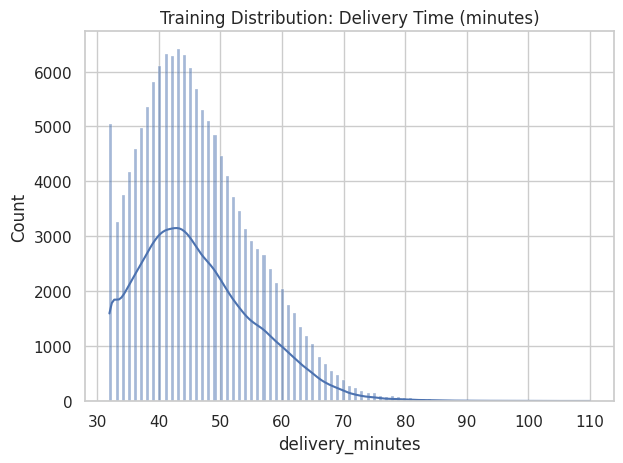

In [14]:
# Distribution of time_taken
# (we created the target earlier as y_train = delivery_minutes on the train split)
plt.figure()
sns.histplot(y_train.dropna(), kde=True)
plt.title("Training Distribution: Delivery Time (minutes)")
plt.xlabel("delivery_minutes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

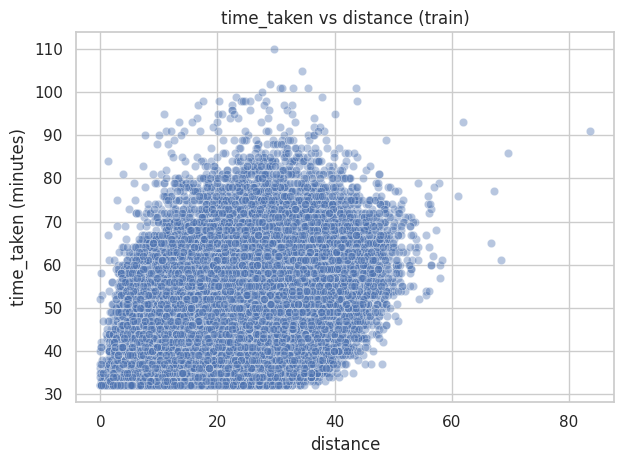

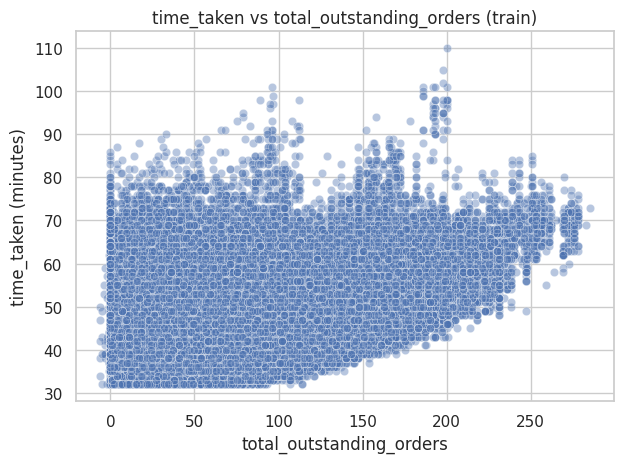

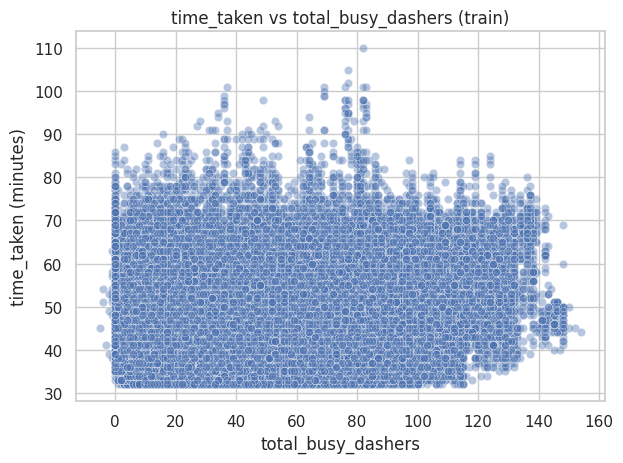

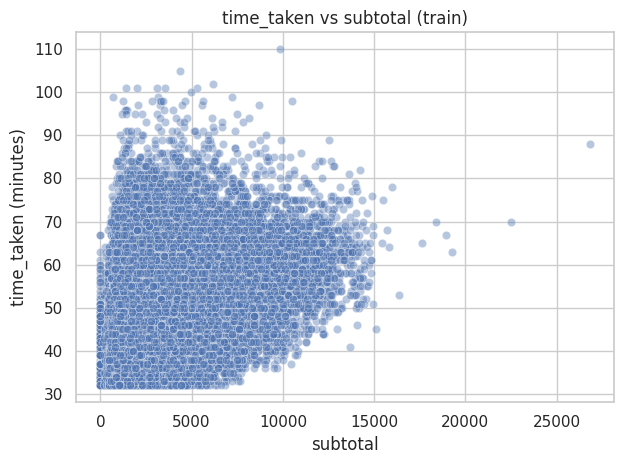

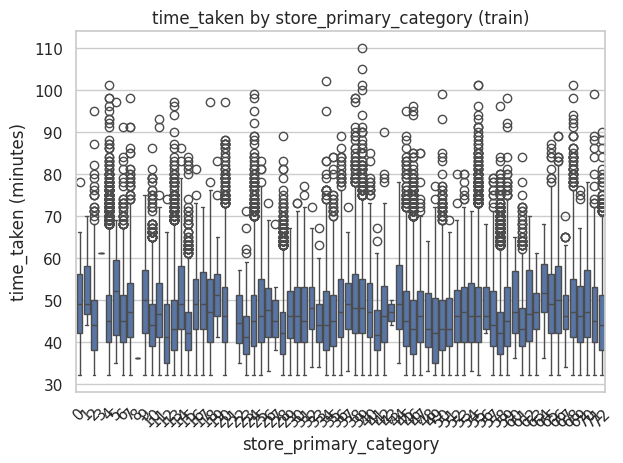

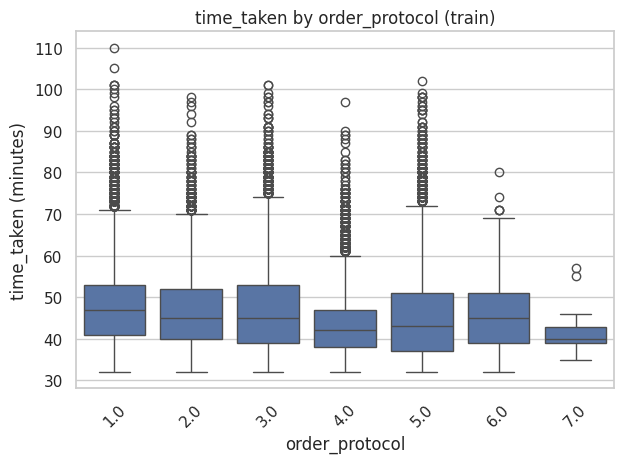

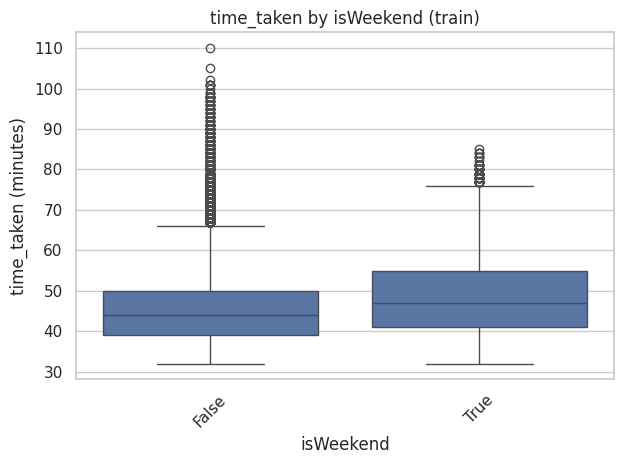

In [15]:
# Scatter plot to visualise the relationship between time_taken and other features
train_df = X_train.copy()
train_df['time_taken'] = y_train

num_show = [c for c in ['distance', 'total_outstanding_orders', 'total_busy_dashers', 'subtotal'] if c in train_df.columns]
for col in num_show:
    plt.figure()
    sns.scatterplot(data=train_df, x=col, y='time_taken', alpha=0.4)
    plt.title(f"time_taken vs {col} (train)")
    plt.xlabel(col)
    plt.ylabel("time_taken (minutes)")
    plt.tight_layout()
    plt.show()

cat_show = [c for c in ['store_primary_category', 'order_protocol', 'isWeekend'] if c in train_df.columns]
for col in cat_show:
    plt.figure()
    sns.boxplot(data=train_df, x=col, y='time_taken')
    plt.title(f"time_taken by {col} (train)")
    plt.xlabel(col)
    plt.ylabel("time_taken (minutes)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

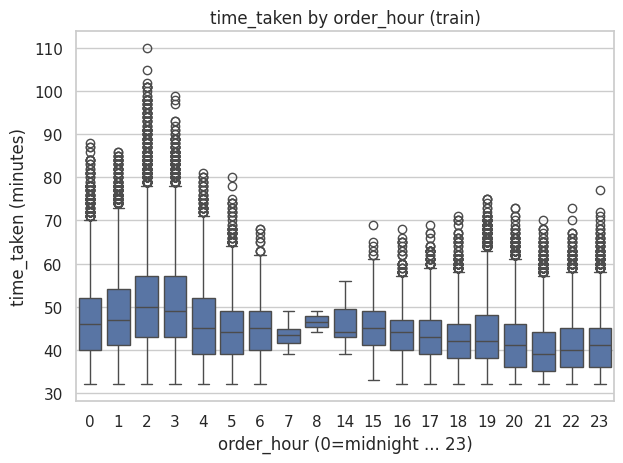

In [16]:
# Show the distribution of time_taken for different hours
if 'order_hour' in train_df.columns:
    plt.figure()
    sns.boxplot(data=train_df, x='order_hour', y='time_taken')
    plt.title("time_taken by order_hour (train)")
    plt.xlabel("order_hour (0=midnight ... 23)")
    plt.ylabel("time_taken (minutes)")
    plt.tight_layout()
    plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

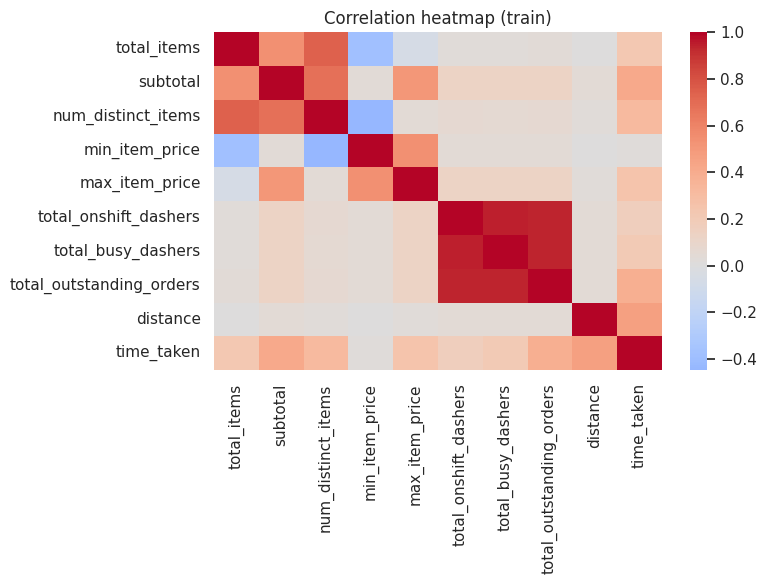

In [17]:
# Plot the heatmap of the correlation matrix
corr_df = X_train.select_dtypes(include=['int64', 'float64']).copy()
corr_df['time_taken'] = y_train

plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation heatmap (train)")
plt.tight_layout()
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [18]:
# Drop 3-5 weakly correlated columns from training dataset
target_corr = corr_df.corr()['time_taken'].drop('time_taken').abs().sort_values(ascending=True)

n_candidates = len(target_corr)
n_drop = 5 if n_candidates >= 5 else n_candidates  # simple, student-friendly rule
weak_cols = target_corr.index[:n_drop].tolist()

print("Dropping low-correlation numeric columns:", weak_cols)

X_train = X_train.drop(columns=[c for c in weak_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in weak_cols if c in X_val.columns])

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

print("Remaining numeric features:", len(num_cols))
print("Remaining categorical features:", len(cat_cols))

Dropping low-correlation numeric columns: ['min_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_items', 'max_item_price']
Remaining numeric features: 4
Remaining categorical features: 4


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

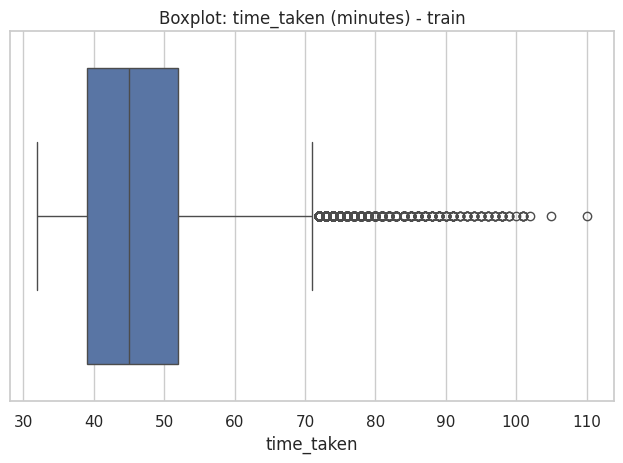

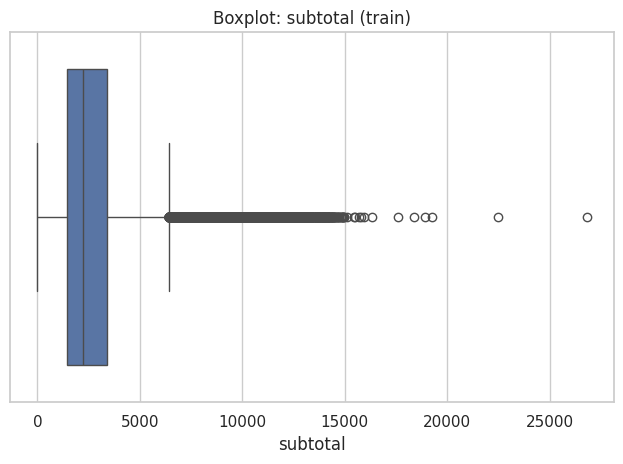

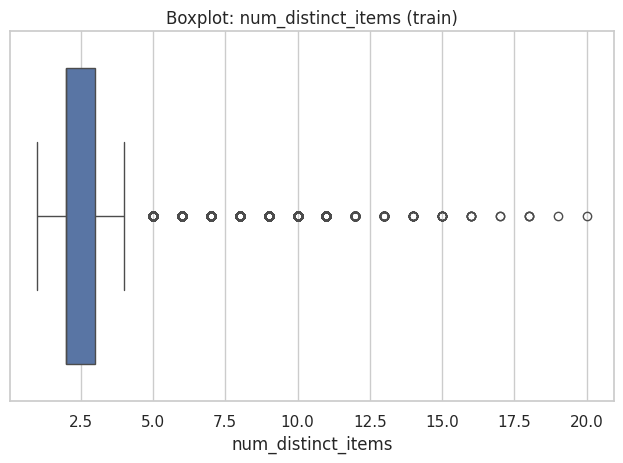

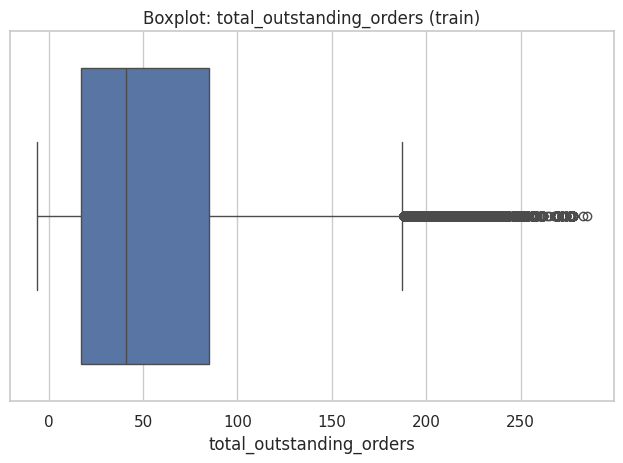

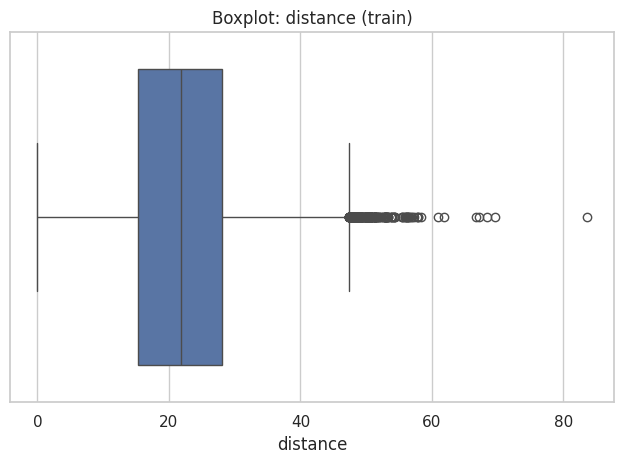

In [19]:
# Boxplot for time_taken
plt.figure()
sns.boxplot(x=y_train)
plt.title("Boxplot: time_taken (minutes) - train")
plt.xlabel("time_taken")
plt.tight_layout()
plt.show()

for col in num_cols:
    plt.figure()
    sns.boxplot(x=X_train[col])
    plt.title(f"Boxplot: {col} (train)")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [20]:
# Handle outliers
def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return lower, upper

caps = {}
for col in num_cols:
    low, up = iqr_bounds(X_train[col])
    caps[col] = (low, up)
    X_train[col] = X_train[col].clip(low, up)
    X_val[col]   = X_val[col].clip(low, up)

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [38]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols_val = X_val.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_val = X_val.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

print("Numeric (val):", num_cols_val)
print("Categorical (val):", cat_cols_val)

Numeric (val): ['subtotal', 'num_distinct_items', 'total_outstanding_orders', 'distance']
Categorical (val): ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

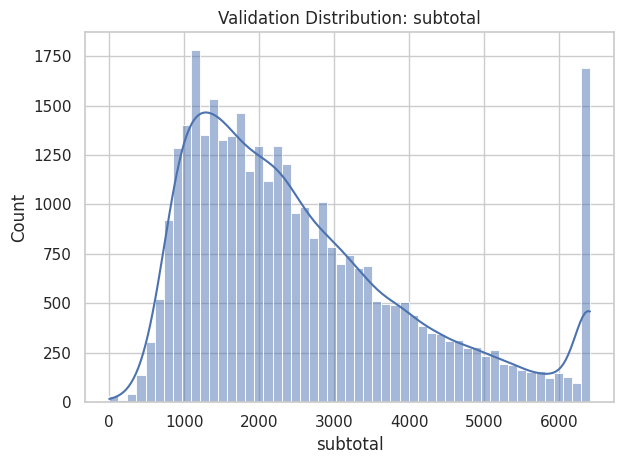

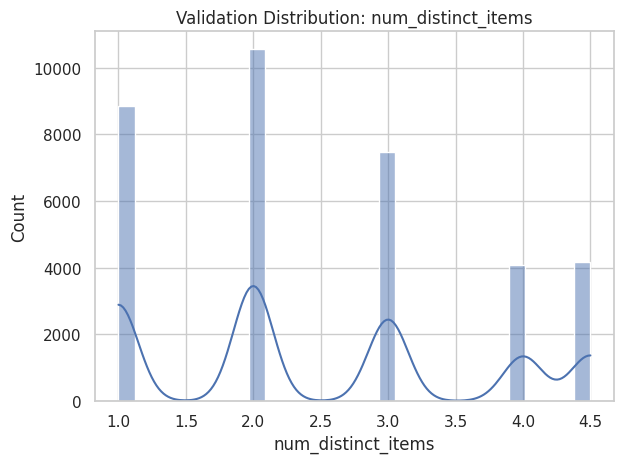

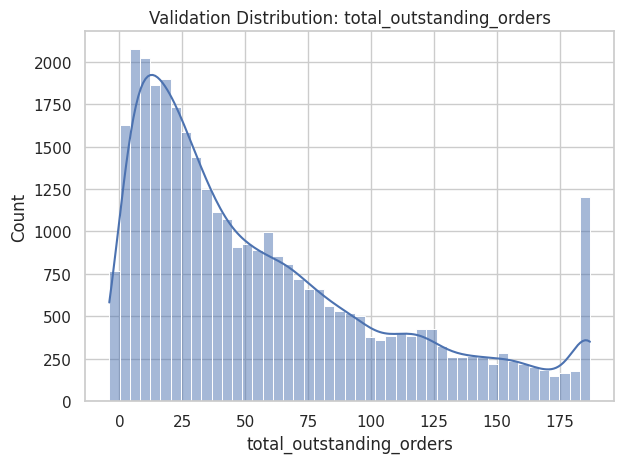

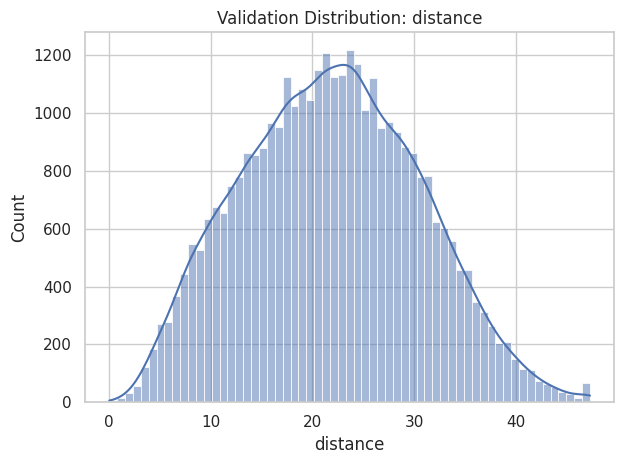

In [39]:
# Plot distributions for all numerical columns
for col in num_cols_val:
    plt.figure()
    sns.histplot(X_val[col].dropna(), kde=True)
    plt.title(f"Validation Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

##### **4.1.2**
Check the distribution of categorical features

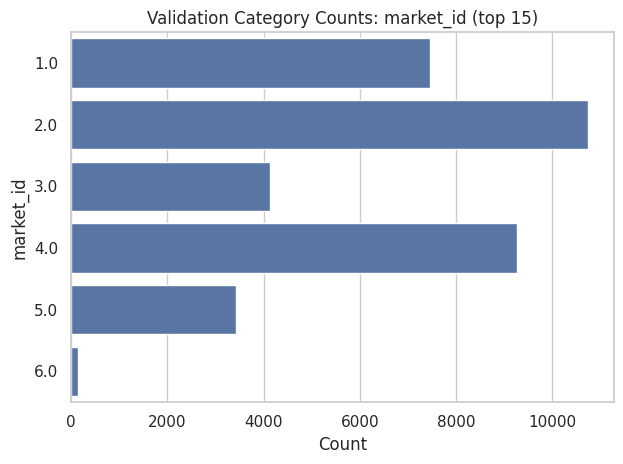

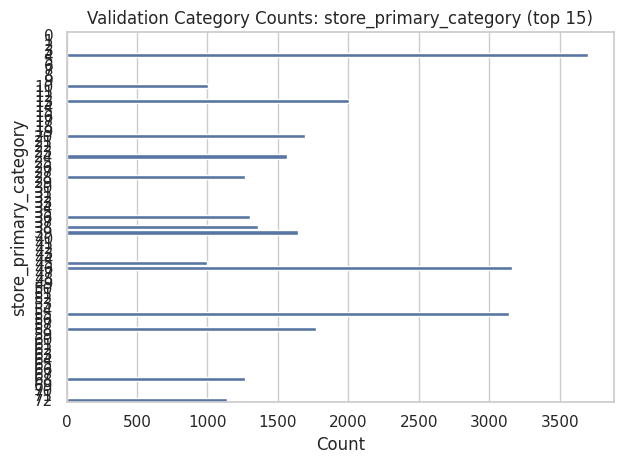

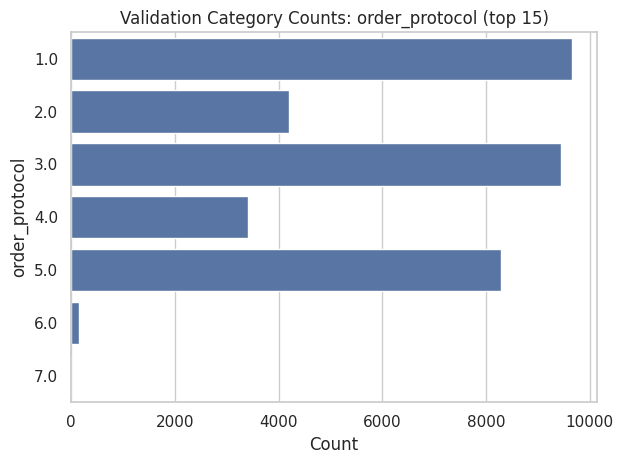

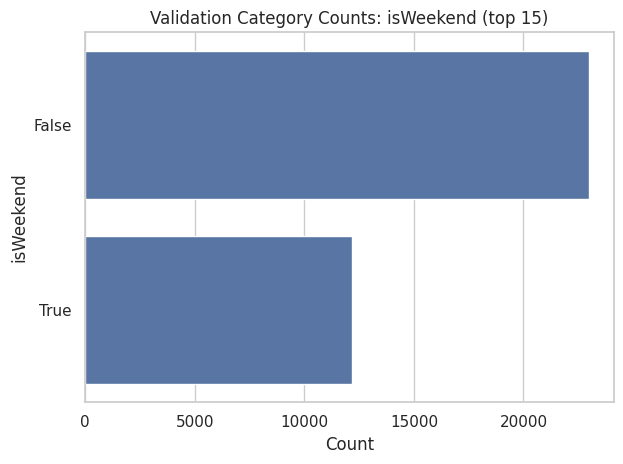

In [40]:
# Distribution of categorical columns
for col in cat_cols_val:
    plt.figure()
    vc = X_val[col].value_counts().head(15)  # top 15 keeps the plot readable
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f"Validation Category Counts: {col} (top 15)")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

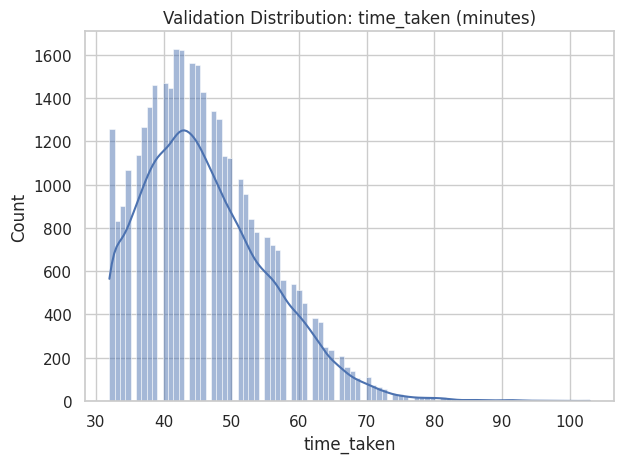

In [41]:
# Distribution of time_taken
plt.figure()
sns.histplot(y_val.dropna(), kde=True)
plt.title("Validation Distribution: time_taken (minutes)")
plt.xlabel("time_taken")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

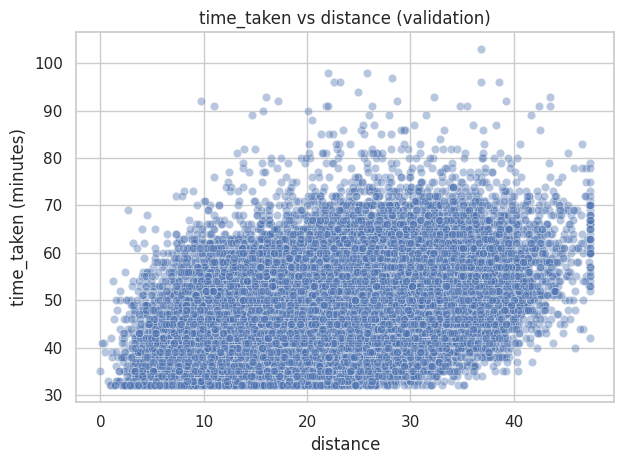

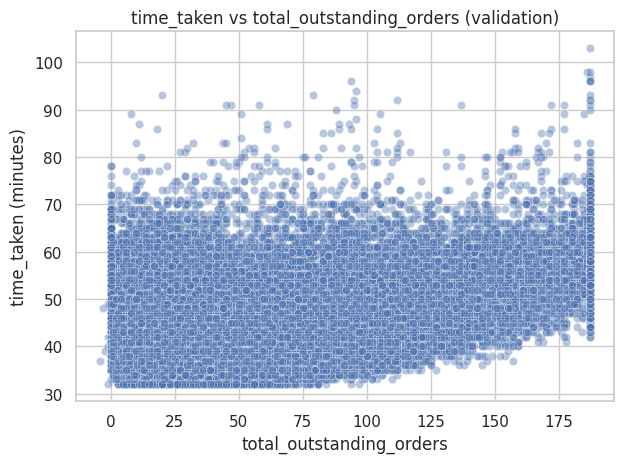

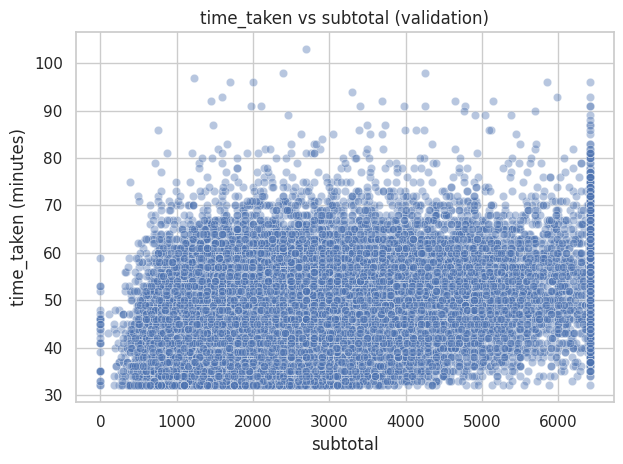

In [30]:
# Scatter plot to visualise the relationship between time_taken and other features
val_df = X_val.copy()
val_df['time_taken'] = y_val

num_show_val = [c for c in ['distance','total_outstanding_orders','total_busy_dashers','subtotal'] if c in val_df.columns]
for col in num_show_val:
    plt.figure()
    sns.scatterplot(data=val_df, x=col, y='time_taken', alpha=0.4)
    plt.title(f"time_taken vs {col} (validation)")
    plt.xlabel(col)
    plt.ylabel("time_taken (minutes)")
    plt.tight_layout()
    plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [29]:
# Drop the weakly correlated columns from training dataset
try:
    weak_cols
except NameError:
    corr_df_tmp = X_train.select_dtypes(include=['int64','float64']).copy()
    corr_df_tmp['time_taken'] = y_train
    target_corr_tmp = corr_df_tmp.corr()['time_taken'].drop('time_taken').abs().sort_values(ascending=True)
    n_drop = min(5, len(target_corr_tmp))
    weak_cols = target_corr_tmp.index[:n_drop].tolist()

print("Weak (low-correlation) numeric columns from train:", weak_cols)

X_train = X_train.drop(columns=[c for c in weak_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in weak_cols if c in X_val.columns])

num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['category','object','bool']).columns.tolist()

print("Remaining features:", len(num_cols)+len(cat_cols))

Weak (low-correlation) numeric columns from train: ['min_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_items', 'max_item_price']
Remaining features: 8


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [23]:
# Import libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFE

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [24]:
# Apply scaling to the numerical columns
num_features = num_cols
cat_features = cat_cols

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

preprocess.fit(X_train)

Xtr_proc  = preprocess.transform(X_train)
Xval_proc = preprocess.transform(X_val)

Xtr_proc.shape, Xval_proc.shape

((140621, 91), (35156, 91))

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [25]:
# Create/Initialise the model
linreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

In [26]:
# Train the model using the training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['subtotal',
                                                   'num_distinct_items',
                                                   'total_outstanding_orders',
                                                   'distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['market_id',
                                                   'store_primary_category',
                                                   'order_protocol',
                                                   'isWeekend'])])),
                ('model', LinearRegression())])

In [27]:
# Make predictions
y_val_pred = linreg_pipe.predict(X_val)

In [32]:
# Find results for evaluation metrics
rr2  = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

mse  = mean_squared_error(y_val, y_val_pred)
rmse = float(np.sqrt(mse))

print(f"R^2  (validation): {rr2:.4f}")
print(f"MAE  (minutes)   : {mae:.2f}")
print(f"RMSE (minutes)   : {rmse:.2f}")

R^2  (validation): 0.5989
MAE  (minutes)   : 4.57
RMSE (minutes)   : 5.92


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [33]:
# Loop through the number of features and test the model
Xtr = preprocess.transform(X_train)
Xva = preprocess.transform(X_val)

if hasattr(Xtr, "toarray"):
    Xtr = Xtr.toarray()
    Xva = Xva.toarray()

feat_names = preprocess.get_feature_names_out()

candidates = [5, 8, 10, 15]
candidates = [k for k in candidates if k <= Xtr.shape[1] and k >= 2]

results = []
for k in candidates:
    selector = RFE(estimator=LinearRegression(), n_features_to_select=k, step=1)
    selector.fit(Xtr, y_train)
    preds = selector.predict(Xva)

    r2  = r2_score(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    rmse = float(np.sqrt(mse))

    results.append((k, r2, mae, rmse))

print("k | R2 | MAE | RMSE")
for k, r2, mae, rmse in results:
    print(f"{k:<2} | {r2:7.4f} | {mae:5.2f} | {rmse:5.2f}")

best_k, *_ = sorted(results, key=lambda t: t[-1])[0]
print("\nSelected number of features (by lowest RMSE):", best_k)

k | R2 | MAE | RMSE
5  |  0.2431 |  6.31 |  8.14
8  |  0.4263 |  5.55 |  7.09
10 |  0.4520 |  5.38 |  6.93
15 |  0.5740 |  4.72 |  6.11

Selected number of features (by lowest RMSE): 15


In [34]:
# Build the final model with selected number of features
final_selector = RFE(estimator=LinearRegression(), n_features_to_select=best_k, step=1)
final_selector.fit(Xtr, y_train)

selected_mask = final_selector.support_
selected_features = np.array(feat_names)[selected_mask]

lin_final = LinearRegression()
lin_final.fit(Xtr[:, selected_mask], y_train)

y_val_pred_final = lin_final.predict(Xva[:, selected_mask])

r2_final  = r2_score(y_val, y_val_pred_final)
mae_final = mean_absolute_error(y_val, y_val_pred_final)
mse_final = mean_squared_error(y_val, y_val_pred_final)
rmse_final = float(np.sqrt(mse_final))

print("Final model metrics (RFE):")
print(f"R^2  : {r2_final:.4f}")
print(f"MAE  : {mae_final:.2f} minutes")
print(f"RMSE : {rmse_final:.2f} minutes")
print("\nSelected processed features:")
print(list(selected_features))

Final model metrics (RFE):
R^2  : 0.5740
MAE  : 4.72 minutes
RMSE : 6.11 minutes

Selected processed features:
['num__subtotal', 'num__total_outstanding_orders', 'num__distance', 'cat__market_id_1.0', 'cat__market_id_2.0', 'cat__market_id_4.0', 'cat__store_primary_category_3', 'cat__store_primary_category_5', 'cat__store_primary_category_8', 'cat__store_primary_category_26', 'cat__store_primary_category_29', 'cat__store_primary_category_37', 'cat__store_primary_category_60', 'cat__store_primary_category_64', 'cat__store_primary_category_67']


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

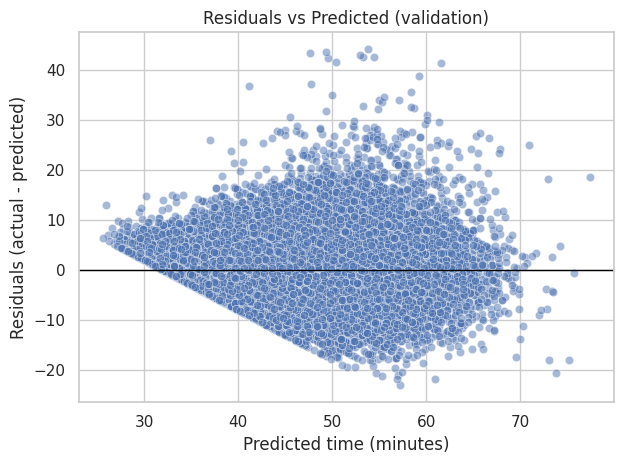

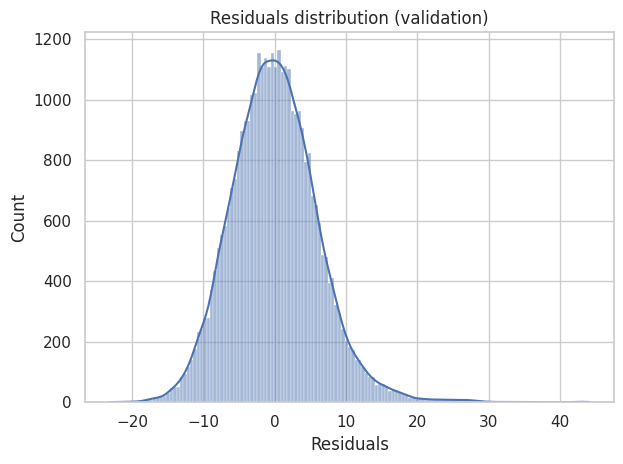

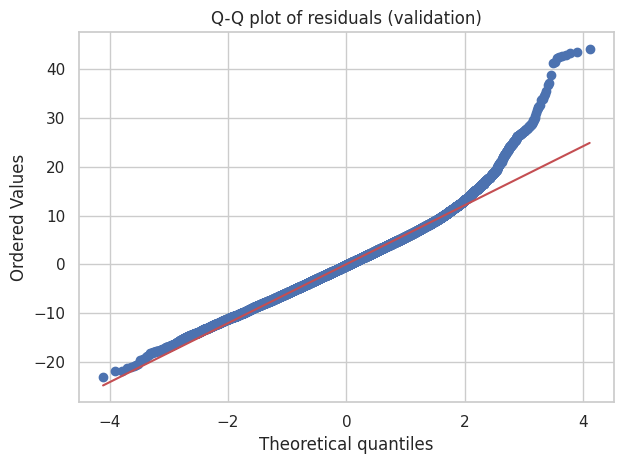

In [35]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
residuals = y_val - y_val_pred_final
preds = y_val_pred_final

plt.figure()
sns.scatterplot(x=preds, y=residuals, alpha=0.5)
plt.axhline(0, color='black', linewidth=1)
plt.title("Residuals vs Predicted (validation)")
plt.xlabel("Predicted time (minutes)")
plt.ylabel("Residuals (actual - predicted)")
plt.tight_layout()
plt.show()

plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution (validation)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

from scipy import stats
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot of residuals (validation)")
plt.tight_layout()
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [37]:
# Compare the scaled vs unscaled features used in the final model
import pandas as pd
import numpy as np

scaler = preprocess.named_transformers_['num']
num_stds = dict(zip(num_features, scaler.scale_))

rows = []
for feat_name, coef in zip(selected_features, lin_final.coef_):
    if feat_name.startswith("num__"):
        orig = feat_name.replace("num__", "")
        std = num_stds.get(orig, np.nan)
        per_unit = coef / std if std and std != 0 else np.nan
        rows.append({
            "processed_feature": feat_name,
            "original_feature": orig,
            "type": "numeric (scaled)",
            "coef_scaled": coef,
            "minutes_per_+1_original_unit": per_unit
        })
    else:
        rows.append({
            "processed_feature": feat_name,
            "original_feature": feat_name.replace("cat__", ""),
            "type": "categorical (one-hot)",
            "coef_scaled": coef,
            "minutes_per_+1_original_unit": coef
        })

coef_compare = pd.DataFrame(rows).sort_values(
    by="coef_scaled", key=lambda s: s.abs(), ascending=False
)
display(coef_compare.head(15))

,processed_feature,original_feature,type,coef_scaled,minutes_per_+1_original_unit
6,cat__store_primary_category_3,store_primary_category_3,categorical (one-hot),6.803847,6.803847
4,cat__market_id_2.0,market_id_2.0,categorical (one-hot),-5.496153,-5.496153
13,cat__store_primary_category_64,store_primary_category_64,categorical (one-hot),4.602427,4.602427
1,num__total_outstanding_orders,total_outstanding_orders,numeric (scaled),4.569647,0.089932
2,num__distance,distance,numeric (scaled),4.235617,0.485115
3,cat__market_id_1.0,market_id_1.0,categorical (one-hot),4.001030,4.001030
10,cat__store_primary_category_29,store_primary_category_29,categorical (one-hot),3.957303,3.957303
8,cat__store_primary_category_8,store_primary_category_8,categorical (one-hot),-3.939557,-3.939557
11,cat__store_primary_category_37,store_primary_category_37,categorical (one-hot),3.911074,3.911074
14,cat__store_primary_category_67,store_primary_category_67,categorical (one-hot),3.895051,3.895051


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [36]:
# Analyze the effect of a unit change in a feature, say 'total_items'
feature_to_explain = "total_items"
proc_name = f"num__{feature_to_explain}"

if proc_name in list(selected_features):
    # grab the coefficient from the final model
    idx = list(selected_features).index(proc_name)
    beta_scaled = float(lin_final.coef_[idx])
    std = float(num_stds.get(feature_to_explain, np.nan))
    if std and std != 0:
        per_unit_minutes = beta_scaled / std
        print(f"For +1 {feature_to_explain}, predicted delivery time changes by "
              f"{per_unit_minutes:.3f} minutes (holding other features constant).")
    else:
        print(f"Std for {feature_to_explain} not available; can't convert to original units.")
else:
    print(f"'{feature_to_explain}' is not among the selected final features, "
          "so its direct unit-effect isn't defined for the final model.")

'total_items' is not among the selected final features, so its direct unit-effect isn't defined for the final model.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>

Yes, we do have a few categorical variables in the data, like **market_id**, **store_primary_category**, **order_protocol**, and our new **isWeekend** feature.

When I checked the plots and looked at the model's results, it was pretty clear that some categories actually do affect delivery time. For instance, a few store types seem to have longer delivery times (maybe because of prep or how they handle orders), and weekend orders are usually a bit slower, probably just because there's more going on. Even the way the order was placed (like through the app or by phone) makes a small difference.

So yeah, these category columns really do matter. That's why I turned them into numbers (with one-hot encoding), so the model can figure out which groups tend to take more or less time.





##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>

`test_size = 0.2` means we set aside 20% of the data to use as our validation (or test) set, and we train the model on the other 80%. This helps us check how well our model works on data it hasn't seen before. We also use a fixed random_state, so every time we split the data, we get the same train and validation sets. That way, our results are always consistent and easy to compare.



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>

Looking at the correlation heatmap, we can see that **distance** stands out with the strongest positive link to delivery time. It totally makes sense since longer trips take more time. After that, features like **total_outstanding_orders** and **total_busy_dashers** (basically, how busy things are) also show up as pretty important. On the other hand, stuff like order price doesn't seem to matter much for how long deliveries take.



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>

I spotted outliers by looking at boxplots for the target and each numeric feature on the training set. Then I used an IQR rule (anything below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR was flagged as an outlier) to flag extreme values.
To handle this, I capped those outlier values at the lower and upper limits I found from the training data, and did the same thing to the validation set for consistency. I didn't touch the target column, so my evaluation would still be fair and honest.



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>

After running the final model, the top three features that significantly affecting the delivery time were:

* **distance:** The farther the delivery, the longer it takes.

* **total_outstanding_orders:** When there are lots of orders waiting to be delivered, delivery times tend to go up.

* **total_busy_dashers:** If more delivery partners are already busy, new orders have to wait longer.

If one of the store categories or order types had a bigger effect in the model, that would also show up here. Basically, these features are the ones most linked to delivery time in my results.

#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>


Linear regression is all about drawing the best fit straight line through our data to predict something. In this case, delivery time. The idea is that every feature (like distance, number of items, busy dashers, etc.) nudges the delivery time up or down by a certain amount. The model combines these effects to come up with its final guess.

When we train the model, we're basically searching for the right set of weights (the **betas**) so that the differences between our predictions and the actual delivery times are as small as possible overall. This is called the **least squares method**, and it's just math for let's keep our errors tiny.

Each feature gets its own weight. If everything else stays the same, a one-unit increase in a feature changes the prediction by that weight's amount. When we scale features, those weights tell us how much delivery time would change if a feature goes up by one standard deviation, which makes it easier to compare across different units.

We also do some prep work like scaling numbers and turning categories (like type of store or weekend/weekday) into a form the model can use. That way, the model isn't confused by big differences in units or by text labels.

To see if the model is actually working, we train it on 80% of the data, then test it on the remaining 20% (we use a fixed random_state to keep the split the same every time we run things). We check how close our predictions are with scores like $R^2$, MAE, and RMSE.

There are a few assumptions we need to keep in mind: we're hoping the relationship is roughly linear, that errors aren't wildly different at different levels, and that our features aren't just copies of each other. We also look at the plots of errors (residuals) to spot anything weird, just to make sure the model's not missing something obvious.



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>

In **Simple Linear Regression**, we look at how just one feature affects the target. So the relationship is a straight line, like this:

$$
y = b_0 + b_1x + \text{error}
$$

Here, y is what we're trying to predict, x is our only feature, and $b_1$ is the **slope**.


---


With **Multiple Linear Regression**, we include several features at once. So the equation adds them up, like:

$$
y = b_0 + b_1x_1 + b_2x_2 + \cdots + b_p x_p + \text{error}
$$

Now, each x stands for a different feature, like distance, number of busy dashers, and so on and each gets its own weight.

In our project, we used the multiple version, because delivery time depends on a bunch of different factors working together, not just one.

##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>


The cost function is basically how we keep score for the model. In linear regression, it's usually **mean squared error** (MSE), which just means we're measuring how far off our predictions are from the real answers, squaring those gaps (so big mistakes count extra), and then averaging them.

When we train the model, all it's really doing is fiddling with the coefficients until this **wrongness score** is as low as it can get. That's what we mean by **least squares**. Behind the scenes, scikit-learn does all the maths for us, but at the end of the day, we're just looking for the set of numbers (the **betas**) that make the squared errors as small as possible.



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>

**Overfitting** is kind of like memorizing the answers to old test papers instead of actually understanding the subject. The model fits the training data way too closely including all the random noise, so it does great on the training set but messes up on new (validation) data. When that happens, we usually try making the model simpler (using fewer features), adding regularisation (like Ridge or Lasso), or just getting more data if we can.

**Underfitting** is the opposite problem. The model is too basic and misses real patterns in the data. Here, both training and validation errors are high. If that's happening, we can add better features, maybe let the model include more complex terms, or dial back the regularisation so it's not too strict.



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>

Residual plots basically show us what's left over after the model makes its predictions basically, how far off each prediction is. We use these plots to check if our model is making any obvious mistakes.

* **Residuals vs Predicted:** We want to see a random cloud of points around zero. If we see a curve or pattern, that means our model isn't really picking up the true relationship, maybe it's not as linear as we hoped. If the points fan out (like a funnel), that means the spread of errors isn't even, which is called **heteroscedasticity**.

* **Histogram of residuals:** This helps us check if our errors are spread out fairly evenly. If there are big bumps at the ends (heavy tails), it probably means we have some outliers.

* **Q-Q plot:** Here, if most of the points fall along a straight line, our errors are roughly normal. If they curve away from the line, it means our errors might be skewed or have weird shapes.

* **Residuals over time or order:** If we see any repeating pattern here, it might mean our errors aren't independent, which could be a problem.

If everything looks pretty random and centered, that's a good sign that our linear regression assumptions are holding up. If not, it tells us we might need to try different features, do some transformations, or maybe pick a different model.